In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import itertools
import random
random.seed(108448)
from scipy.stats import poisson

#%pip install gurobipy
import gurobipy as gp
from gurobipy import GRB

Data generation

In [87]:
#Define the number of elements in each set I, J, K
i_num = 27
k_num = 5
j_num = 700 #Without I and K, so real j_num_real = j_num + i_num + k_num
degree_to_m = 111111

#Define empty data frames
I_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])



In [20]:
#Define sets of I, J, K, where J contains I and K

# for i in range(i_num):
#     I.loc[i, 'Point number'] = 'i'+ str(i)
#     I.loc[i, 'Latitude'] = round(random.uniform(0, 25000), 0)
#     I.loc[i, 'Longitude'] = round(random.uniform(0, 25000), 0)

# I.index = I['Point number']
    
    
# for k in range(k_num):
#     K.loc[k, 'Point number'] = 'k'+ str(k)
#     K.loc[k, 'Latitude'] = round(random.uniform(0, 25000), 0)
#     K.loc[k, 'Longitude'] = round(random.uniform(0, 25000), 0)

# K.index = K['Point number']


# for j in range(j_num):
#     J.loc[j, 'Point number'] = 'j'+ str(j)
#     J.loc[j, 'Latitude'] = round(random.uniform(0, 25000), 0)
#     J.loc[j, 'Longitude'] = round(random.uniform(0, 25000), 0)

# J.index = J['Point number'] 
# J = pd.concat([J, K, I], axis = 0) #Include K to J
# J

In [97]:
#Define sets of I, J, K, where J contains I and K for Passau

#Define the number of elements in each set I, J, K
i_num = 27
k_num = 5
j_num = 700 #Without I and K, so real j_num_real = j_num + i_num + k_num
degree_to_m = 111111

#Define empty data frames
I_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
J_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])
K_coordinates = pd.DataFrame(columns = ['Point number', 'Latitude', 'Longitude'])

doctors = pd.read_csv('Doctors coordinates.txt', sep = ';', index_col = False)

doctors

for i in range(len(doctors['Latitude'])):
    I_coordinates.loc[i, 'Point number'] = 'i'+ str(i)
    I_coordinates.loc[i, 'Latitude'] = doctors.loc[i, 'Latitude']
    I_coordinates.loc[i, 'Longitude'] = doctors.loc[i, 'Longitude']

I_coordinates.index = I_coordinates['Point number']

I = I_coordinates * degree_to_m
I['Point number'] = I_coordinates['Point number']


labs = pd.read_csv('Labs coordinates.txt', sep = ';', index_col = False) 
labs

for k in range(len(labs['Latitude'])):
    K_coordinates.loc[k, 'Point number'] = 'k'+ str(k)
    K_coordinates.loc[k, 'Latitude'] = labs.loc[k, 'Latitude']
    K_coordinates.loc[k, 'Longitude'] = labs.loc[k, 'Longitude']

K_coordinates.index = K_coordinates['Point number']

K = K_coordinates * degree_to_m
K['Point number'] = K_coordinates['Point number']


#Define range of coordinates

combined_coordinates = pd.concat([I_coordinates, K_coordinates])

min_latitude = combined_coordinates['Latitude'].min()
max_latitude = combined_coordinates['Latitude'].max()
min_longitude = combined_coordinates['Longitude'].min()
max_longitude = combined_coordinates['Longitude'].max()

for j in range(j_num):
    J_coordinates.loc[j, 'Point number'] = 'j'+ str(j)
    J_coordinates.loc[j, 'Latitude'] = round(random.uniform(min_latitude - 2000/degree_to_m, max_latitude + 2000/degree_to_m), 6)
    J_coordinates.loc[j, 'Longitude'] = round(random.uniform(min_longitude - 2000/degree_to_m, max_longitude + 2000/degree_to_m), 6)

J_coordinates.index = J_coordinates['Point number'] 
J_coordinates = pd.concat([J_coordinates, K_coordinates, I_coordinates], axis = 0) #Include K to J
J_coordinates

J = J_coordinates * degree_to_m
J['Point number'] = J_coordinates['Point number']

# K

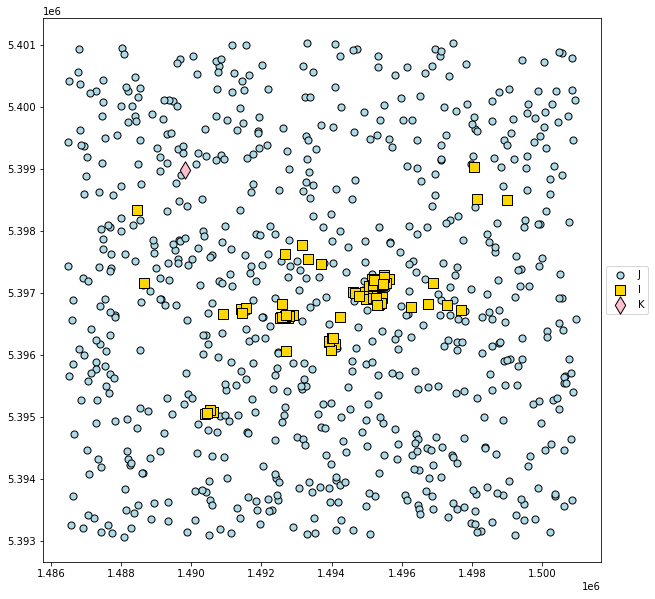

In [98]:
axs, fig = plt.subplots(1, 1, figsize = (10, 10))

fig.scatter(J['Longitude'], J['Latitude'], color = 'lightblue', edgecolors = 'black',
            marker = 'o', s = 50, label = 'J')
fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
            marker = 's', s = 100, label = 'I')
fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
            marker = 'd', s = 150, label = 'K')
fig.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [101]:
from pathlib import Path
import pandas as pd
import geopandas as gpd
import shapely
#%pip install folium matplotlib mapclassify
import folium
import matplotlib



with open('Polygon Passau.txt', 'r') as file:
    # Read the contents of the file into a string
    polygon_str = file.read()

# Making Passau polygon

passau_map = folium.Map(location=[48.565, 13.433], zoom_start=12)

passau_poly = shapely.wkt.loads(polygon_str)
passau_gdf = gpd.GeoDataFrame(geometry=[passau_poly], crs="epsg:4326")
folium.GeoJson(passau_gdf).add_to(passau_map)


# Assuming I_coordinates is your DataFrame with doctor coordinates
geo_doctors = gpd.GeoDataFrame(I_coordinates, geometry=gpd.points_from_xy(I_coordinates["Latitude"], I_coordinates["Longitude"]), crs="epsg:4326")

for idx, row in geo_doctors.iterrows():
    coordinates_label = f"Lat: {row['Latitude']}, Long: {row['Longitude']}"
    folium.Marker([row['Latitude'], row['Longitude']], 
                  icon=folium.Icon(icon='circle', prefix='fa', color='orange'), 
                  popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
    
geo_labs = gpd.GeoDataFrame(K_coordinates, geometry=gpd.points_from_xy(K_coordinates["Latitude"], K_coordinates["Longitude"]), crs="epsg:4326")

for idx, row in geo_labs.iterrows():
    coordinates_label = f"Lat: {row['Latitude']}, Long: {row['Longitude']}"
    folium.Marker([row['Latitude'], row['Longitude']], 
                  icon=folium.Icon(icon='circle', prefix='fa', color='red'), 
                  popup=folium.Popup(coordinates_label, parse_html=True)).add_to(passau_map)
    

# lines = []
# for i in range(len(geo_doctors) - 1):
#     point1 = geo_doctors.iloc[i].geometry
#     point2 = geo_doctors.iloc[i + 1].geometry
#     lines.append([point1.coords[0], point2.coords[0]])

# folium.PolyLine(lines, color='blue').add_to(passau_map)



passau_map

In [24]:
#Define constants

B = 17 * (90 * 60) #battery load: seconds of travel
S = 17 * (10 * 60) #meters of service time
alpha = 14760 + 500 #euro

beta = {}
for j in J.index:
    if j.startswith('j'):
        beta[j] = 400000
    else:
        beta[j] = 300000
        
gamma = 0.0045 / 1000 # variable cost in euro per m
        
q_j = {j: 50 for j in J.index}

up_bound = 12
mu = {i : int(round(random.uniform(0, up_bound), 0)) for i in I.index}

softlimit = 200
hardlimit = 10000

Deterministic model

In [25]:
theta_det = {}
for n in I.index:
    theta_det[n] = list(poisson.rvs(mu[n], size = 1))[0]
theta_det

{'i0': 8,
 'i1': 5,
 'i2': 0,
 'i3': 10,
 'i4': 15,
 'i5': 12,
 'i6': 1,
 'i7': 12,
 'i8': 2,
 'i9': 8,
 'i10': 7,
 'i11': 0,
 'i12': 5,
 'i13': 6,
 'i14': 13,
 'i15': 3,
 'i16': 4,
 'i17': 1,
 'i18': 6,
 'i19': 11,
 'i20': 2,
 'i21': 0,
 'i22': 12,
 'i23': 6,
 'i24': 9,
 'i25': 0,
 'i26': 7,
 'i27': 13,
 'i28': 10,
 'i29': 2,
 'i30': 0,
 'i31': 6,
 'i32': 6,
 'i33': 6,
 'i34': 2,
 'i35': 4,
 'i36': 0,
 'i37': 4,
 'i38': 15,
 'i39': 0,
 'i40': 2,
 'i41': 4,
 'i42': 4,
 'i43': 10,
 'i44': 5,
 'i45': 2,
 'i46': 9,
 'i47': 15,
 'i48': 0,
 'i49': 0,
 'i50': 9,
 'i51': 1,
 'i52': 10,
 'i53': 3,
 'i54': 13,
 'i55': 5,
 'i56': 4,
 'i57': 3,
 'i58': 3,
 'i59': 15,
 'i60': 2,
 'i61': 1,
 'i62': 9,
 'i63': 0,
 'i64': 5,
 'i65': 0,
 'i66': 5,
 'i67': 12,
 'i68': 9,
 'i69': 1,
 'i70': 13,
 'i71': 3,
 'i72': 5,
 'i73': 6,
 'i74': 6,
 'i75': 3,
 'i76': 6}

In [26]:
#Define distance matrices

def distance(point1, PointsSet1, point2, PointsSet2):
    c1 = np.array((PointsSet1.loc[point1, 'Latitude'], PointsSet1.loc[point1, 'Longitude']))
    c2 = np.array((PointsSet2.loc[point2, 'Latitude'], PointsSet2.loc[point2, 'Longitude']))
    return np.linalg.norm(c1-c2)

dist_JI = {(c1, c2): distance(c1, J, c2, I)for c1, c2 in itertools.product(J.index, I.index)}
dist_IK = {(c1, c2): distance(c1, I, c2, K)for c1, c2 in itertools.product(I.index, K.index)}
dist_KJ = {(c1, c2): distance(c1, K, c2, J)for c1, c2 in itertools.product(K.index, J.index)}
 
dist_KJ


{('k0', 'j0'): 1923.567884824709,
 ('k0', 'j1'): 2179.0352146267164,
 ('k0', 'j2'): 6163.473615482851,
 ('k0', 'j3'): 6063.517690511948,
 ('k0', 'j4'): 2389.6881693143728,
 ('k0', 'j5'): 6844.3832983387065,
 ('k0', 'j6'): 4324.042889004638,
 ('k0', 'j7'): 10778.148743416783,
 ('k0', 'j8'): 9403.588316756737,
 ('k0', 'j9'): 9849.21602963946,
 ('k0', 'j10'): 8451.677158976376,
 ('k0', 'j11'): 1750.954954286253,
 ('k0', 'j12'): 8707.833403677949,
 ('k0', 'j13'): 10759.105867751974,
 ('k0', 'j14'): 8428.48641000624,
 ('k0', 'j15'): 3536.413017985476,
 ('k0', 'j16'): 6268.312334252522,
 ('k0', 'j17'): 5603.826961716409,
 ('k0', 'j18'): 3072.5067516185536,
 ('k0', 'j19'): 5534.875001386562,
 ('k0', 'j20'): 1201.2034353088602,
 ('k0', 'j21'): 1251.3594977579273,
 ('k0', 'j22'): 5267.891831734348,
 ('k0', 'j23'): 4461.585123489926,
 ('k0', 'j24'): 6890.065504877083,
 ('k0', 'j25'): 5716.353513384341,
 ('k0', 'j26'): 2752.37962077015,
 ('k0', 'j27'): 2637.6177862956465,
 ('k0', 'j28'): 749.6965

In [27]:
#Define set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= 0.5*B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [28]:
#Define set P
P = list()
for i, k in itertools.product(I.index, K.index):
    if dist_IK[(i, k)] <= 0.5*B:
        P.append((i, k))
        
P

[('i0', 'k0'),
 ('i1', 'k0'),
 ('i2', 'k0'),
 ('i3', 'k0'),
 ('i4', 'k0'),
 ('i5', 'k0'),
 ('i6', 'k0'),
 ('i7', 'k0'),
 ('i8', 'k0'),
 ('i9', 'k0'),
 ('i10', 'k0'),
 ('i11', 'k0'),
 ('i12', 'k0'),
 ('i13', 'k0'),
 ('i14', 'k0'),
 ('i15', 'k0'),
 ('i16', 'k0'),
 ('i17', 'k0'),
 ('i18', 'k0'),
 ('i19', 'k0'),
 ('i20', 'k0'),
 ('i21', 'k0'),
 ('i22', 'k0'),
 ('i23', 'k0'),
 ('i24', 'k0'),
 ('i25', 'k0'),
 ('i26', 'k0'),
 ('i27', 'k0'),
 ('i28', 'k0'),
 ('i29', 'k0'),
 ('i30', 'k0'),
 ('i31', 'k0'),
 ('i32', 'k0'),
 ('i33', 'k0'),
 ('i34', 'k0'),
 ('i35', 'k0'),
 ('i36', 'k0'),
 ('i37', 'k0'),
 ('i38', 'k0'),
 ('i39', 'k0'),
 ('i40', 'k0'),
 ('i41', 'k0'),
 ('i42', 'k0'),
 ('i43', 'k0'),
 ('i44', 'k0'),
 ('i45', 'k0'),
 ('i46', 'k0'),
 ('i47', 'k0'),
 ('i48', 'k0'),
 ('i49', 'k0'),
 ('i50', 'k0'),
 ('i51', 'k0'),
 ('i52', 'k0'),
 ('i53', 'k0'),
 ('i54', 'k0'),
 ('i55', 'k0'),
 ('i56', 'k0'),
 ('i57', 'k0'),
 ('i58', 'k0'),
 ('i59', 'k0'),
 ('i60', 'k0'),
 ('i61', 'k0'),
 ('i62', 'k0'),
 (

In [29]:
#Define sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_final = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_final.keys())
KJ_feas


[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [30]:
#Define sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_final = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_final.keys())
N_i

{'i0': [('k0', 'j0'),
  ('k0', 'j1'),
  ('k0', 'j2'),
  ('k0', 'j3'),
  ('k0', 'j4'),
  ('k0', 'j5'),
  ('k0', 'j6'),
  ('k0', 'j7'),
  ('k0', 'j8'),
  ('k0', 'j9'),
  ('k0', 'j10'),
  ('k0', 'j11'),
  ('k0', 'j12'),
  ('k0', 'j13'),
  ('k0', 'j14'),
  ('k0', 'j15'),
  ('k0', 'j16'),
  ('k0', 'j17'),
  ('k0', 'j18'),
  ('k0', 'j20'),
  ('k0', 'j21'),
  ('k0', 'j22'),
  ('k0', 'j23'),
  ('k0', 'j24'),
  ('k0', 'j25'),
  ('k0', 'j28'),
  ('k0', 'j30'),
  ('k0', 'j31'),
  ('k0', 'j33'),
  ('k0', 'j34'),
  ('k0', 'j35'),
  ('k0', 'j37'),
  ('k0', 'j38'),
  ('k0', 'j39'),
  ('k0', 'j40'),
  ('k0', 'j41'),
  ('k0', 'j43'),
  ('k0', 'j44'),
  ('k0', 'j45'),
  ('k0', 'j47'),
  ('k0', 'j48'),
  ('k0', 'j49'),
  ('k0', 'j50'),
  ('k0', 'j51'),
  ('k0', 'j52'),
  ('k0', 'j54'),
  ('k0', 'j55'),
  ('k0', 'j56'),
  ('k0', 'j58'),
  ('k0', 'j59'),
  ('k0', 'j60'),
  ('k0', 'j61'),
  ('k0', 'j62'),
  ('k0', 'j63'),
  ('k0', 'j65'),
  ('k0', 'j66'),
  ('k0', 'j67'),
  ('k0', 'j68'),
  ('k0', 'j69'),
 

In [31]:
#Define sets O_j

O_j = {}
O_interim = []

for j in J.index:
    for (i, k) in P:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] + dist_KJ[k, j] <= B:
                O_interim.append((i, k))
    O_j[j] = O_interim
    O_interim = []
    
O_j_final = {key : val for key, val in O_j.items() if val != []}   
 
J_feas = list(O_j_final.keys())
J_feas

['j0',
 'j1',
 'j2',
 'j3',
 'j4',
 'j5',
 'j6',
 'j7',
 'j8',
 'j9',
 'j10',
 'j11',
 'j12',
 'j13',
 'j14',
 'j15',
 'j16',
 'j17',
 'j18',
 'j19',
 'j20',
 'j21',
 'j22',
 'j23',
 'j24',
 'j25',
 'j26',
 'j27',
 'j28',
 'j29',
 'j30',
 'j31',
 'j32',
 'j33',
 'j34',
 'j35',
 'j36',
 'j37',
 'j38',
 'j39',
 'j40',
 'j41',
 'j42',
 'j43',
 'j44',
 'j45',
 'j46',
 'j47',
 'j48',
 'j49',
 'j50',
 'j51',
 'j52',
 'j53',
 'j54',
 'j55',
 'j56',
 'j57',
 'j58',
 'j59',
 'j60',
 'j61',
 'j62',
 'j63',
 'j64',
 'j65',
 'j66',
 'j67',
 'j68',
 'j69',
 'j70',
 'j71',
 'j72',
 'j73',
 'j74',
 'j75',
 'j76',
 'j77',
 'j78',
 'j79',
 'j80',
 'j81',
 'j82',
 'j83',
 'j84',
 'j85',
 'j86',
 'j87',
 'j88',
 'j89',
 'j90',
 'j91',
 'j92',
 'j93',
 'j94',
 'j95',
 'j96',
 'j97',
 'j98',
 'j99',
 'j100',
 'j101',
 'j102',
 'j103',
 'j104',
 'j105',
 'j106',
 'j107',
 'j108',
 'j109',
 'j110',
 'j111',
 'j112',
 'j113',
 'j114',
 'j115',
 'j116',
 'j117',
 'j118',
 'j119',
 'j120',
 'j121',
 'j122',
 'j

In [32]:
model_det = gp.Model('Deterministic model without relaxation')

x_ikj = model_det.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [33]:
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'c2')
model_det.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_det.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_det.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

{('i0', 'k0', 'j0'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j1'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j2'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j3'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j6'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j7'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j9'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j11'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j12'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j13'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j14'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 (

In [34]:
model_det.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

def softtime(model, where):
    if where == GRB.Callback.MIP:
        runtime = model.cbGet(GRB.Callback.RUNTIME)
        objbst = model.cbGet(GRB.Callback.MIP_OBJBST)
        objbnd = model.cbGet(GRB.Callback.MIP_OBJBND)
        gap = abs((objbst - objbnd) / objbst)

        if runtime > softlimit and gap < 0.5:
            model.terminate()
            
model_det.setParam('TimeLimit', hardlimit)
model_det.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 120667 rows, 60684 columns and 238670 nonzeros
Model fingerprint: 0x3167f01a
Variable types: 0 continuous, 60684 integer (778 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+04]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 3.055339e+07
Presolve removed 119823 rows and 9308 columns
Presolve time: 0.33s
Presolved: 844 rows, 51376 columns, 101974 nonzeros
Variable types: 0 continuous, 51376 integer (4633 binary)
Found heuristic solution: objective 2.895339e+07

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0         

In [35]:
def ListSolution(model):
        nSolutions = model.SolCount
        print('Number of solutions found: ' + str(nSolutions))
        for e in range(nSolutions):
        #for iter2 in range(1):
                model.setParam(GRB.Param.SolutionNumber, e)
                print(e)
                print('%g ' % model.PoolObjVal, end='\n')
                for v in model.getVars():
                        if v.X > 0:
                                print ('%s %g' % (v.varName, v.X))
                                #print(v)
                print("\n")
                
        print("\n")
        
ListSolution(model_det)

Number of solutions found: 10
0
9.35338e+06 
x_ikj[i0,k0,k0] 6
x_ikj[i0,k0,i23] 2
x_ikj[i1,k0,k0] 5
x_ikj[i3,k0,i43] 10
x_ikj[i4,k0,i62] 15
x_ikj[i5,k0,i12] 8
x_ikj[i5,k0,i62] 4
x_ikj[i6,k0,i46] 1
x_ikj[i7,k0,i12] 12
x_ikj[i8,k0,i12] 2
x_ikj[i9,k0,i46] 8
x_ikj[i10,k0,i46] 7
x_ikj[i12,k0,i12] 5
x_ikj[i13,k0,i46] 6
x_ikj[i14,k0,i19] 2
x_ikj[i14,k0,i52] 5
x_ikj[i14,k0,i59] 6
x_ikj[i15,k0,i52] 2
x_ikj[i15,k0,i59] 1
x_ikj[i16,k0,i19] 4
x_ikj[i17,k0,k0] 1
x_ikj[i18,k0,k0] 6
x_ikj[i19,k0,i19] 11
x_ikj[i20,k0,i19] 2
x_ikj[i22,k0,i12] 9
x_ikj[i22,k0,i46] 3
x_ikj[i23,k0,i23] 6
x_ikj[i24,k0,i19] 6
x_ikj[i24,k0,i59] 3
x_ikj[i26,k0,i12] 7
x_ikj[i27,k0,i62] 13
x_ikj[i28,k0,i23] 10
x_ikj[i29,k0,i43] 2
x_ikj[i31,k0,i23] 6
x_ikj[i32,k0,k0] 6
x_ikj[i33,k0,i52] 6
x_ikj[i34,k0,i62] 2
x_ikj[i35,k0,i23] 1
x_ikj[i35,k0,i43] 2
x_ikj[i35,k0,i62] 1
x_ikj[i37,k0,i23] 4
x_ikj[i38,k0,i23] 15
x_ikj[i40,k0,i62] 2
x_ikj[i41,k0,i62] 4
x_ikj[i42,k0,i46] 4
x_ikj[i43,k0,i43] 10
x_ikj[i44,k0,k0] 5
x_ikj[i45,k0,i52] 2
x_ik

In [36]:
def SolutionSummary(model):
    n = -1
    results = pd.DataFrame(columns = ['i', 'k', 'j', 'Number of drones'])
    for opt_sol in range(1):
        for v in model.getVars():
            if v.varName.startswith('x_ikj'):
                if v.X > 0:
                    n += 1
                    indices = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                    results.loc[n, 'i'] = indices[0]
                    results.loc[n, 'k'] = indices[1]
                    results.loc[n, 'j'] = indices[2]
                    results.loc[n, 'Number of drones'] = int(v.X)
    results_doctors = results.groupby('i', as_index = False)['Number of drones'].sum()
    results_locations = results.groupby('j', as_index = False)['Number of drones'].sum()
    results_labs = results.groupby('k', as_index = False)['Number of drones'].sum()
    return results_doctors, results_locations, results_labs

SolutionSummary(model_det)

(      i  Number of drones
 0    i0                 8
 1    i1                 5
 2   i10                 7
 3   i12                 5
 4   i13                 6
 ..  ...               ...
 61  i74                 6
 62  i75                 3
 63  i76                 6
 64   i8                 2
 65   i9                 8
 
 [66 rows x 2 columns],
      j  Number of drones
 0  i12                50
 1  i19                37
 2  i23                50
 3  i43                50
 4  i46                50
 5  i52                50
 6  i59                49
 7  i62                50
 8   k0                50,
     k  Number of drones
 0  k0               436)

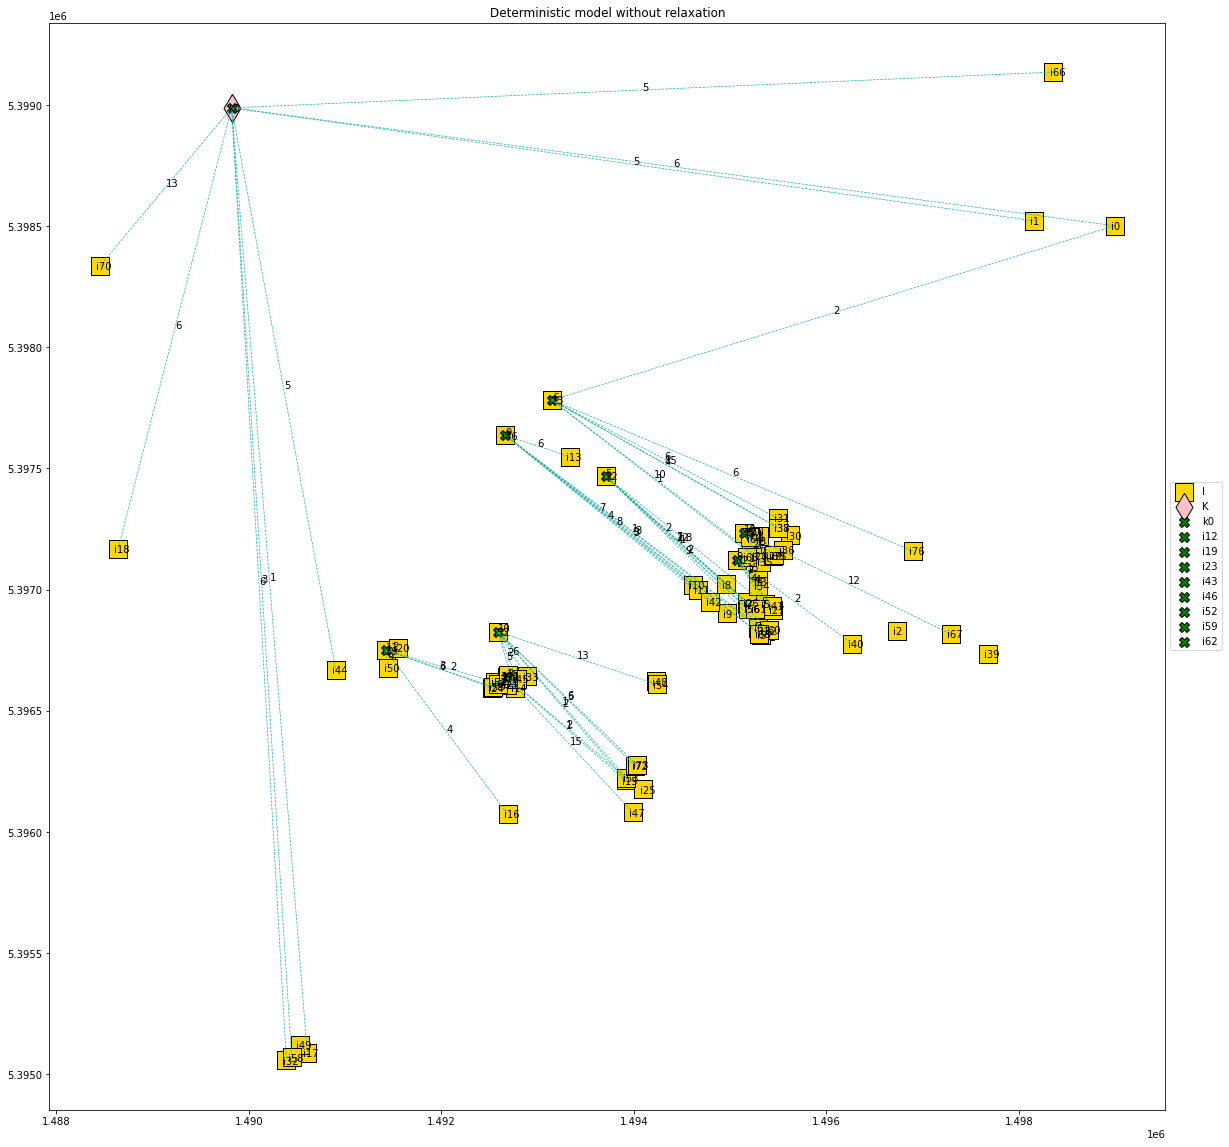

In [37]:
def SolutionGraph(I, K, J, model):
        
        axs, fig = plt.subplots(1, 1, figsize = (20, 20))
                
        fig.scatter(I['Longitude'], I['Latitude'], color = 'gold', edgecolors = 'black',
                                marker = 's', s = 300, label = 'I')
        for i in range (len(I.index)):
                fig.annotate(I.index[i], (I['Longitude'][i] - 40, I['Latitude'][i] - 15))
                
        fig.scatter(K['Longitude'], K['Latitude'], color = 'pink', edgecolors = 'black',
                                marker = 'd', s = 400, label = 'K')
        for k in range (len(K.index)):
                fig.annotate(K.index[k], (K['Longitude'][k] - 40, K['Latitude'][k] - 15))
        
        fig.set_title(model.ModelName)
        model.setParam(GRB.Param.SolutionNumber, 0)
        for v in model.getVars():
                if v.xn > 0:
                        if v.varName.startswith('x_ikj'):
                                indices_x = v.varName[6:-1].split(',') #drop variable name and brackets and convert to a list of indices
                                fig.plot((J.loc[indices_x[2], 'Longitude'], I.loc[indices_x[0], 'Longitude']),
                                        (J.loc[indices_x[2], 'Latitude'], I.loc[indices_x[0], 'Latitude']),
                                        color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                # fig.plot((I.loc[indices_x[0], 'Longitude'], K.loc[indices_x[1], 'Longitude']),
                                #         (I.loc[indices_x[0], 'Latitude'], K.loc[indices_x[1], 'Latitude']),
                                        # color = 'lightseagreen', linestyle = "--", linewidth = 0.7)
                                #fig.annotate(str(int(v.xn)), xy = ((K.loc[indices_x[1], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2,
                                                                #(K.loc[indices_x[1], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2))
                                fig.annotate(str(int(v.xn)), xy = ((J.loc[indices_x[2], 'Longitude'] + I.loc[indices_x[0], 'Longitude'])/2,
                                                                (J.loc[indices_x[2], 'Latitude'] + I.loc[indices_x[0], 'Latitude'])/2))
                        else:
                                index_y = v.varName[4:-1]
                                fig.scatter(J.loc[index_y, 'Longitude'], J.loc[index_y, 'Latitude'], color = 'green',
                                        edgecolors = 'black', s = 100, marker = 'X', label = index_y)
                fig.legend(loc = 'center left', bbox_to_anchor = (1, 0.5))
    

SolutionGraph(I, K, J, model_det)

Probabilistic model

In [38]:
#Define constants and random variables

theta_ran_i = {}
for n in list(I.index):
    theta_ran_i[n] = poisson(mu[n])

p = 0.98

l_i = {}
for i in theta_ran_i.keys():
    l_i[i] = int(theta_ran_i[i].ppf(p))


g_i = {}
for i in theta_ran_i.keys():
    g_i[i] = mu[i] * 5

IG = []
for i in I.index:
    for g in range(1, g_i[i] + 1):
        IG.append((i, g))

I_feasG = []
for i in I_feas:
    for g in range(1, g_i[i] + 1):
        I_feasG.append((i, g))
        

h_ig = {}
for (i, g) in IG:
    h_ig[(i, g)] = math.log(theta_ran_i[i].cdf(l_i[i] + g)) - math.log(theta_ran_i[i].cdf(l_i[i] + g - 1))


phi = float(math.log(p) - sum(theta_ran_i[i].cdf(l_i[i]) for i in I_feas))

In [39]:
model_prob = gp.Model('Probabilistic model without relaxation')

x_ikj = model_prob.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [40]:
#Probabilistic constraints

model_prob.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i0', 1): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 2): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 3): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 4): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 5): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 6): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 7): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 8): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 9): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 10): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 11): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 12): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 13): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 14): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 15): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 16): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 17): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 18): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 19): <gurobi.Constr *Awaiting

In [41]:
#Same constraints as in the deterministic model

model_prob.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_prob.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_prob.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

{('i0', 'k0', 'j0'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j1'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j2'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j3'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j6'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j7'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j9'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j11'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j12'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j13'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j14'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 (

In [42]:
model_prob.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)

In [43]:
model_prob.setParam('TimeLimit', hardlimit)
model_prob.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 122761 rows, 62854 columns and 6552015 nonzeros
Model fingerprint: 0x78ce07bb
Variable types: 0 continuous, 62854 integer (2948 binary)
Coefficient statistics:
  Matrix range     [1e-13, 9e+04]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 8e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 3.995222e+07
Presolve removed 121911 rows and 6865 columns (presolve time = 5s) ...
Presolve removed 121911 rows and 6865 columns
Presolve time: 5.13s
Presolved: 850 rows, 55989 columns, 111270 nonzeros
Variable types: 0 continuous, 55989 integer (778 binary)
Found 

In [44]:
ListSolution(model_prob)

Number of solutions found: 7
0
1.75522e+07 
x_ikj[i0,k0,i23] 12
x_ikj[i1,k0,i23] 9
x_ikj[i2,k0,i74] 7
x_ikj[i3,k0,i43] 15
x_ikj[i3,k0,i74] 5
x_ikj[i4,k0,i62] 14
x_ikj[i5,k0,i5] 16
x_ikj[i6,k0,i12] 3
x_ikj[i7,k0,i8] 13
x_ikj[i8,k0,i8] 14
x_ikj[i9,k0,i13] 10
x_ikj[i10,k0,i13] 14
x_ikj[i12,k0,i12] 12
x_ikj[i13,k0,i13] 10
x_ikj[i14,k0,i59] 12
x_ikj[i15,k0,i53] 7
x_ikj[i16,k0,i19] 3
x_ikj[i16,k0,i55] 7
x_ikj[i17,k0,i49] 5
x_ikj[i18,k0,k0] 17
x_ikj[i19,k0,i19] 13
x_ikj[i20,k0,i19] 7
x_ikj[i21,k0,i55] 1
x_ikj[i21,k0,i59] 4
x_ikj[i22,k0,i12] 14
x_ikj[i23,k0,i23] 10
x_ikj[i24,k0,i55] 16
x_ikj[i26,k0,i8] 12
x_ikj[i27,k0,i5] 18
x_ikj[i28,k0,i12] 4
x_ikj[i28,k0,i23] 1
x_ikj[i28,k0,i43] 13
x_ikj[i29,k0,i74] 5
x_ikj[i31,k0,i23] 10
x_ikj[i32,k0,i49] 9
x_ikj[i33,k0,i52] 16
x_ikj[i34,k0,i62] 7
x_ikj[i35,k0,i12] 2
x_ikj[i35,k0,i62] 12
x_ikj[i36,k0,i74] 3
x_ikj[i37,k0,i23] 1
x_ikj[i37,k0,i38] 6
x_ikj[i38,k0,i38] 18
x_ikj[i40,k0,i5] 2
x_ikj[i40,k0,i62] 3
x_ikj[i41,k0,i5] 14
x_ikj[i42,k0,i46] 5
x_ikj[i43,k

In [45]:
SolutionSummary(model_prob)

(      i  Number of drones
 0    i0                12
 1    i1                 9
 2   i10                14
 3   i12                12
 4   i13                10
 ..  ...               ...
 67  i74                16
 68  i75                 5
 69  i76                 9
 70   i8                14
 71   i9                10
 
 [72 rows x 2 columns],
       j  Number of drones
 0   i12                50
 1   i13                50
 2   i19                40
 3   i23                50
 4   i38                50
 5   i43                50
 6   i46                50
 7   i49                26
 8    i5                50
 9   i52                50
 10  i53                50
 11  i55                50
 12  i59                50
 13  i62                50
 14  i74                50
 15   i8                50
 16   k0                50,
     k  Number of drones
 0  k0               816)

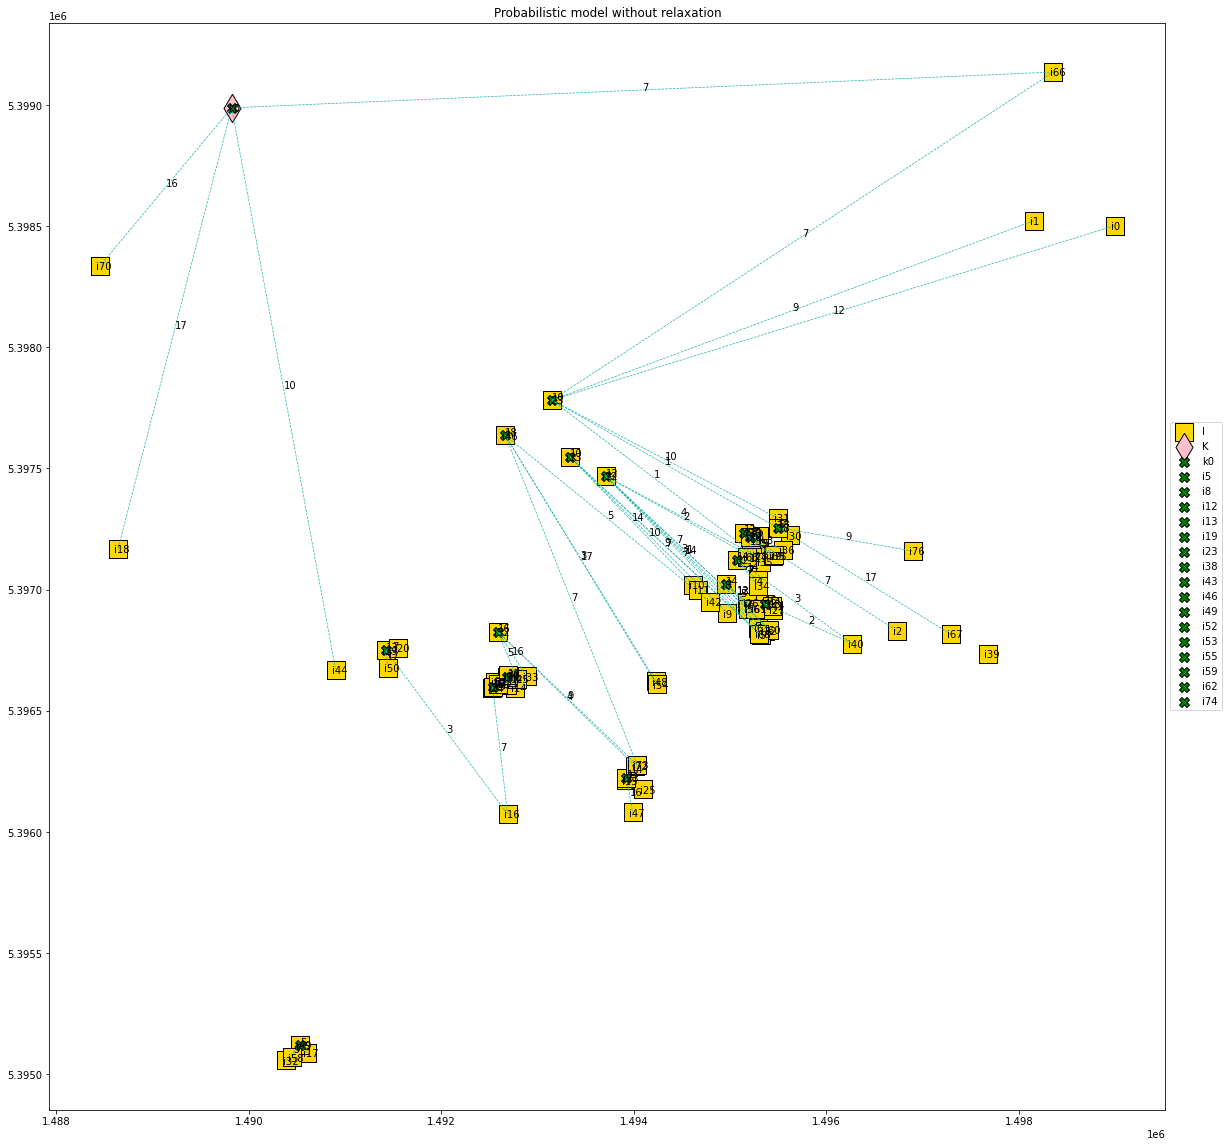

In [46]:
SolutionGraph(I, K, J, model_prob)

Probabilistic model with relaxed constraints

In [47]:
#Redefine set L
L = list()
for k, j in itertools.product(K.index, J.index):
    if dist_KJ[(k, j)] <= B:
        L.append((k, j))
        
L

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [48]:
#Redefine set P
P = list()
for i, k in itertools.product(I.index, K.index):
    if dist_IK[(i, k)] <= B:
        P.append((i, k))
        
P

[('i0', 'k0'),
 ('i1', 'k0'),
 ('i2', 'k0'),
 ('i3', 'k0'),
 ('i4', 'k0'),
 ('i5', 'k0'),
 ('i6', 'k0'),
 ('i7', 'k0'),
 ('i8', 'k0'),
 ('i9', 'k0'),
 ('i10', 'k0'),
 ('i11', 'k0'),
 ('i12', 'k0'),
 ('i13', 'k0'),
 ('i14', 'k0'),
 ('i15', 'k0'),
 ('i16', 'k0'),
 ('i17', 'k0'),
 ('i18', 'k0'),
 ('i19', 'k0'),
 ('i20', 'k0'),
 ('i21', 'k0'),
 ('i22', 'k0'),
 ('i23', 'k0'),
 ('i24', 'k0'),
 ('i25', 'k0'),
 ('i26', 'k0'),
 ('i27', 'k0'),
 ('i28', 'k0'),
 ('i29', 'k0'),
 ('i30', 'k0'),
 ('i31', 'k0'),
 ('i32', 'k0'),
 ('i33', 'k0'),
 ('i34', 'k0'),
 ('i35', 'k0'),
 ('i36', 'k0'),
 ('i37', 'k0'),
 ('i38', 'k0'),
 ('i39', 'k0'),
 ('i40', 'k0'),
 ('i41', 'k0'),
 ('i42', 'k0'),
 ('i43', 'k0'),
 ('i44', 'k0'),
 ('i45', 'k0'),
 ('i46', 'k0'),
 ('i47', 'k0'),
 ('i48', 'k0'),
 ('i49', 'k0'),
 ('i50', 'k0'),
 ('i51', 'k0'),
 ('i52', 'k0'),
 ('i53', 'k0'),
 ('i54', 'k0'),
 ('i55', 'k0'),
 ('i56', 'k0'),
 ('i57', 'k0'),
 ('i58', 'k0'),
 ('i59', 'k0'),
 ('i60', 'k0'),
 ('i61', 'k0'),
 ('i62', 'k0'),
 (

In [49]:
#Redefine sets M_kj

M_kj = {}
M_interim = []

for (k, j) in L:
    for i in I.index:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                M_interim.append(i)
    M_kj[(k, j)] = M_interim
    M_interim = []

M_kj_interim = {key : val for key, val in M_kj.items() if val != []}  

KJ_feas = list(M_kj_interim.keys())
KJ_feas

[('k0', 'j0'),
 ('k0', 'j1'),
 ('k0', 'j2'),
 ('k0', 'j3'),
 ('k0', 'j4'),
 ('k0', 'j5'),
 ('k0', 'j6'),
 ('k0', 'j7'),
 ('k0', 'j8'),
 ('k0', 'j9'),
 ('k0', 'j10'),
 ('k0', 'j11'),
 ('k0', 'j12'),
 ('k0', 'j13'),
 ('k0', 'j14'),
 ('k0', 'j15'),
 ('k0', 'j16'),
 ('k0', 'j17'),
 ('k0', 'j18'),
 ('k0', 'j19'),
 ('k0', 'j20'),
 ('k0', 'j21'),
 ('k0', 'j22'),
 ('k0', 'j23'),
 ('k0', 'j24'),
 ('k0', 'j25'),
 ('k0', 'j26'),
 ('k0', 'j27'),
 ('k0', 'j28'),
 ('k0', 'j29'),
 ('k0', 'j30'),
 ('k0', 'j31'),
 ('k0', 'j32'),
 ('k0', 'j33'),
 ('k0', 'j34'),
 ('k0', 'j35'),
 ('k0', 'j36'),
 ('k0', 'j37'),
 ('k0', 'j38'),
 ('k0', 'j39'),
 ('k0', 'j40'),
 ('k0', 'j41'),
 ('k0', 'j42'),
 ('k0', 'j43'),
 ('k0', 'j44'),
 ('k0', 'j45'),
 ('k0', 'j46'),
 ('k0', 'j47'),
 ('k0', 'j48'),
 ('k0', 'j49'),
 ('k0', 'j50'),
 ('k0', 'j51'),
 ('k0', 'j52'),
 ('k0', 'j53'),
 ('k0', 'j54'),
 ('k0', 'j55'),
 ('k0', 'j56'),
 ('k0', 'j57'),
 ('k0', 'j58'),
 ('k0', 'j59'),
 ('k0', 'j60'),
 ('k0', 'j61'),
 ('k0', 'j62'),
 (

In [50]:
#Redefine sets N_i

N_i = {}
N_interim = []

for i in I.index:
    for (k, j) in L:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                N_interim.append((k, j))
    N_i[i] = N_interim
    N_interim = []
    
N_i_interim = {key : val for key, val in N_i.items() if val != []}   
 
I_feas = list(N_i_interim.keys())

In [51]:
#Define sets O_j

O_j = {}
O_interim = []

for j in J.index:
    for (i, k) in P:
        if dist_JI[j, i] <= S:
            if dist_JI[j, i] + dist_IK[i, k] <= B:
                O_interim.append((i, k))
    O_j[j] = O_interim
    O_interim = []
    
O_j_final = {key : val for key, val in O_j.items() if val != []}   
 
J_feas = list(O_j_final.keys())
J_feas

['j0',
 'j1',
 'j2',
 'j3',
 'j4',
 'j5',
 'j6',
 'j7',
 'j8',
 'j9',
 'j10',
 'j11',
 'j12',
 'j13',
 'j14',
 'j15',
 'j16',
 'j17',
 'j18',
 'j19',
 'j20',
 'j21',
 'j22',
 'j23',
 'j24',
 'j25',
 'j26',
 'j27',
 'j28',
 'j29',
 'j30',
 'j31',
 'j32',
 'j33',
 'j34',
 'j35',
 'j36',
 'j37',
 'j38',
 'j39',
 'j40',
 'j41',
 'j42',
 'j43',
 'j44',
 'j45',
 'j46',
 'j47',
 'j48',
 'j49',
 'j50',
 'j51',
 'j52',
 'j53',
 'j54',
 'j55',
 'j56',
 'j57',
 'j58',
 'j59',
 'j60',
 'j61',
 'j62',
 'j63',
 'j64',
 'j65',
 'j66',
 'j67',
 'j68',
 'j69',
 'j70',
 'j71',
 'j72',
 'j73',
 'j74',
 'j75',
 'j76',
 'j77',
 'j78',
 'j79',
 'j80',
 'j81',
 'j82',
 'j83',
 'j84',
 'j85',
 'j86',
 'j87',
 'j88',
 'j89',
 'j90',
 'j91',
 'j92',
 'j93',
 'j94',
 'j95',
 'j96',
 'j97',
 'j98',
 'j99',
 'j100',
 'j101',
 'j102',
 'j103',
 'j104',
 'j105',
 'j106',
 'j107',
 'j108',
 'j109',
 'j110',
 'j111',
 'j112',
 'j113',
 'j114',
 'j115',
 'j116',
 'j117',
 'j118',
 'j119',
 'j120',
 'j121',
 'j122',
 'j

In [52]:
# #Redefine constants and random variables


# I_feasG = []
# for i in I_feas:
#     for g in range(1, g_i[i] + 1):
#         I_feasG.append((i, g))

In [53]:
model_prob_rel = gp.Model('Probabilistic model with relaxation')

x_ikj = model_prob_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_prob_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')
z_ig = model_prob_rel.addVars(IG, vtype = GRB.BINARY, name = 'z_ig')

In [54]:

model_prob_rel.addConstr((gp.quicksum(h_ig[ig] * z_ig[ig] for ig in I_feasG)) >= phi, name = 'c15')
model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i[i]) == l_i[i] + gp.quicksum(z_ig) for (i, g) in I_feasG), name = 'c16')

model_prob_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_prob_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_prob_rel.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

Warning for adding constraints: zero or small (< 1e-13) coefficients, ignored


{('i0', 'k0', 'j0'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j1'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j2'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j3'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j6'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j7'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j9'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j11'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j12'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j13'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j14'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 (

In [55]:
model_prob_rel.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)
model_prob_rel.setParam('TimeLimit', hardlimit)
model_prob_rel.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 122761 rows, 62854 columns and 6552015 nonzeros
Model fingerprint: 0x6a2de2ec
Variable types: 0 continuous, 62854 integer (2948 binary)
Coefficient statistics:
  Matrix range     [1e-13, 9e+04]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [3e+00, 8e+01]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Found heuristic solution: objective 3.995222e+07
Presolve removed 121911 rows and 6865 columns
Presolve time: 4.65s
Presolved: 850 rows, 55989 columns, 111270 nonzeros
Variable types: 0 continuous, 55989 integer (778 binary)
Found heuristic solution: objective 3.995221e+07

Root simplex log...

Iterat

In [56]:
ListSolution(model_prob_rel)

Number of solutions found: 7
0
1.75522e+07 
x_ikj[i0,k0,i23] 12
x_ikj[i1,k0,i23] 9
x_ikj[i2,k0,i74] 7
x_ikj[i3,k0,i43] 15
x_ikj[i3,k0,i74] 5
x_ikj[i4,k0,i62] 14
x_ikj[i5,k0,i5] 16
x_ikj[i6,k0,i12] 3
x_ikj[i7,k0,i8] 13
x_ikj[i8,k0,i8] 14
x_ikj[i9,k0,i13] 10
x_ikj[i10,k0,i13] 14
x_ikj[i12,k0,i12] 12
x_ikj[i13,k0,i13] 10
x_ikj[i14,k0,i59] 12
x_ikj[i15,k0,i53] 7
x_ikj[i16,k0,i19] 3
x_ikj[i16,k0,i55] 7
x_ikj[i17,k0,i49] 5
x_ikj[i18,k0,k0] 17
x_ikj[i19,k0,i19] 13
x_ikj[i20,k0,i19] 7
x_ikj[i21,k0,i55] 1
x_ikj[i21,k0,i59] 4
x_ikj[i22,k0,i12] 14
x_ikj[i23,k0,i23] 10
x_ikj[i24,k0,i55] 16
x_ikj[i26,k0,i8] 12
x_ikj[i27,k0,i5] 18
x_ikj[i28,k0,i12] 4
x_ikj[i28,k0,i23] 1
x_ikj[i28,k0,i43] 13
x_ikj[i29,k0,i74] 5
x_ikj[i31,k0,i23] 10
x_ikj[i32,k0,i49] 9
x_ikj[i33,k0,i52] 16
x_ikj[i34,k0,i62] 7
x_ikj[i35,k0,i12] 2
x_ikj[i35,k0,i62] 12
x_ikj[i36,k0,i74] 3
x_ikj[i37,k0,i23] 1
x_ikj[i37,k0,i38] 6
x_ikj[i38,k0,i38] 18
x_ikj[i40,k0,i5] 2
x_ikj[i40,k0,i62] 3
x_ikj[i41,k0,i5] 14
x_ikj[i42,k0,i46] 5
x_ikj[i43,k

In [57]:
SolutionSummary(model_prob_rel)

(      i  Number of drones
 0    i0                12
 1    i1                 9
 2   i10                14
 3   i12                12
 4   i13                10
 ..  ...               ...
 67  i74                16
 68  i75                 5
 69  i76                 9
 70   i8                14
 71   i9                10
 
 [72 rows x 2 columns],
       j  Number of drones
 0   i12                50
 1   i13                50
 2   i19                40
 3   i23                50
 4   i38                50
 5   i43                50
 6   i46                50
 7   i49                26
 8    i5                50
 9   i52                50
 10  i53                50
 11  i55                50
 12  i59                50
 13  i62                50
 14  i74                50
 15   i8                50
 16   k0                50,
     k  Number of drones
 0  k0               816)

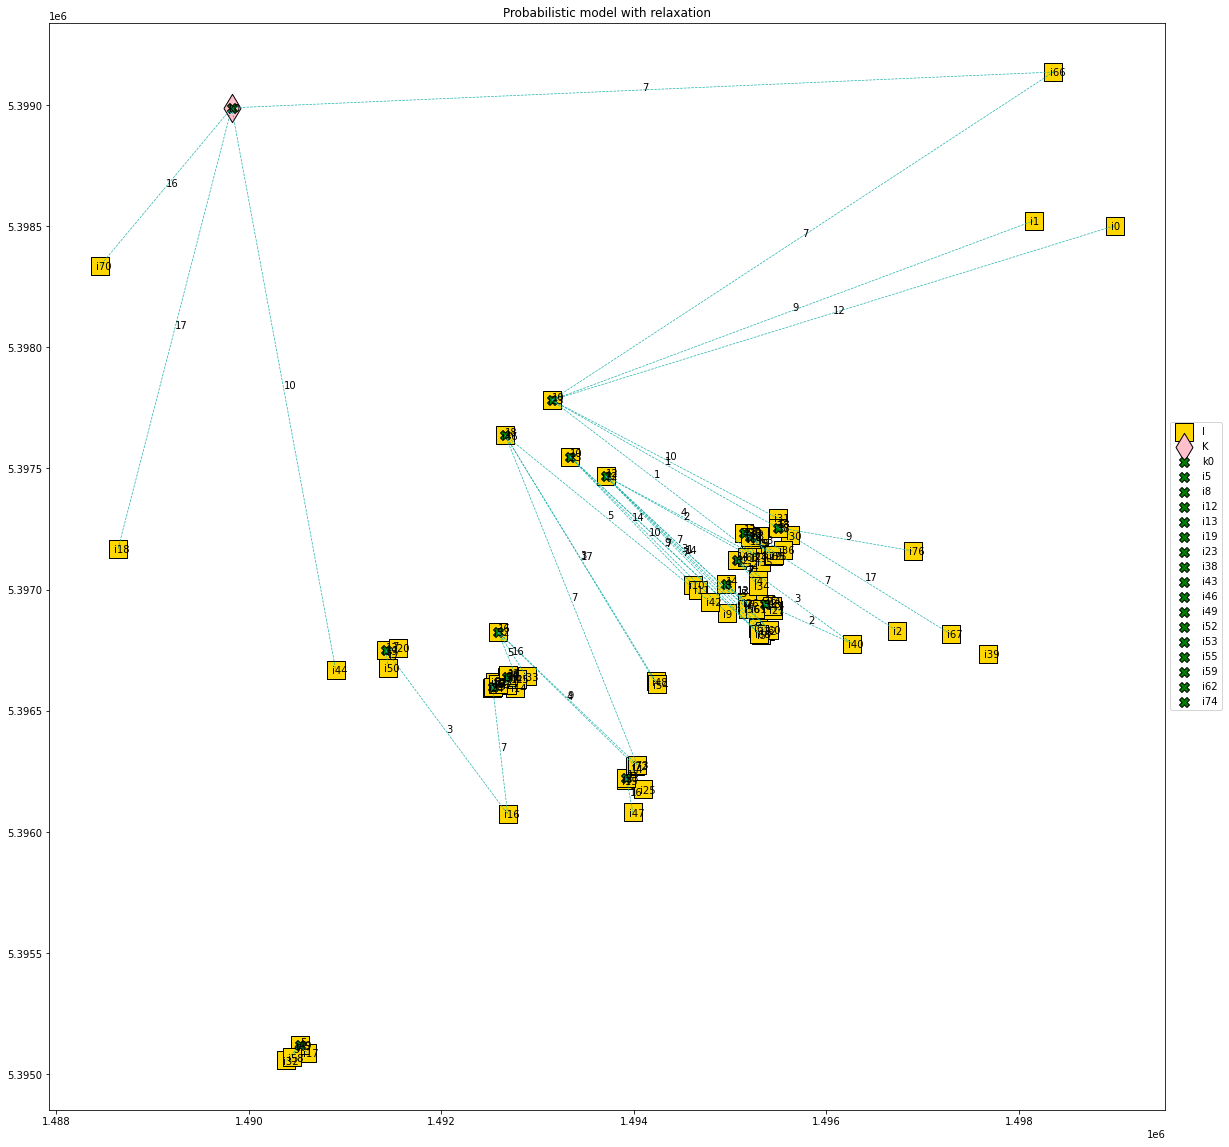

In [58]:
SolutionGraph(I, K, J, model_prob_rel)

Deterministic model with relaxed constraints

In [59]:
model_det_rel = gp.Model('Deterministic model with relaxation')

x_ikj = model_det_rel.addVars(I.index, L, vtype = GRB.INTEGER, name = 'x_ikj')
y_j = model_det_rel.addVars(J.index, vtype = GRB.BINARY, name = 'y_j')

In [60]:
model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (k, j) in N_i_final[i]) >= theta_det[i] for i in I_feas), name = 'c2')

model_det_rel.addConstrs((gp.quicksum(x_ikj[i, k, j] for (i, k) in O_j_final[j]) <= q_j[j] * y_j[j] for j in J_feas), name = 'c4')
model_det_rel.addConstrs(((dist_JI[(j, i)] + dist_IK[(i, k)]) * x_ikj[i, k, j] <= B * x_ikj[i, k, j]
                  for i in I_feas for (k, j) in KJ_feas), name = 'c5')
model_det_rel.addConstrs((dist_JI[(j, i)] * x_ikj[i, k, j] <= S * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas), name = 'c6')

{('i0', 'k0', 'j0'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j1'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j2'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j3'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j4'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j5'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j6'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j7'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j8'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j9'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j10'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j11'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j12'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j13'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j14'): <gurobi.Constr *Awaiting Model Update*>,
 ('i0', 'k0', 'j15'): <gurobi.Constr *Awaiting Model Update*>,
 (

In [61]:
model_det_rel.setObjective(gp.quicksum(alpha * x_ikj[i, k, j] + gamma * (dist_JI[(j, i)] + dist_IK[(i, k)] + dist_KJ[(k, j)]) * x_ikj[i, k, j] for i in I_feas for (k, j) in KJ_feas) + gp.quicksum(beta[j] * y_j[j] for j in J_feas), GRB.MINIMIZE)
model_det_rel.setParam('TimeLimit', hardlimit)
model_det_rel.optimize(softtime)

Set parameter TimeLimit to value 10000
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i5-1145G7 @ 2.60GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 120667 rows, 60684 columns and 238670 nonzeros
Model fingerprint: 0xdff52c4a
Variable types: 0 continuous, 60684 integer (778 binary)
Coefficient statistics:
  Matrix range     [1e-02, 9e+04]
  Objective range  [2e+04, 4e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+01]
Found heuristic solution: objective 3.055339e+07
Presolve removed 119823 rows and 9308 columns
Presolve time: 0.31s
Presolved: 844 rows, 51376 columns, 101974 nonzeros
Variable types: 0 continuous, 51376 integer (4633 binary)
Found heuristic solution: objective 2.895339e+07

Starting sifting (using dual simplex for sub-problems)...

    Iter     Pivots    Primal Obj      Dual Obj        Time
       0         

In [62]:
ListSolution(model_det_rel)

Number of solutions found: 10
0
9.35338e+06 
x_ikj[i0,k0,k0] 6
x_ikj[i0,k0,i23] 2
x_ikj[i1,k0,k0] 5
x_ikj[i3,k0,i43] 10
x_ikj[i4,k0,i62] 15
x_ikj[i5,k0,i12] 8
x_ikj[i5,k0,i62] 4
x_ikj[i6,k0,i46] 1
x_ikj[i7,k0,i12] 12
x_ikj[i8,k0,i12] 2


x_ikj[i9,k0,i46] 8
x_ikj[i10,k0,i46] 7
x_ikj[i12,k0,i12] 5
x_ikj[i13,k0,i46] 6
x_ikj[i14,k0,i19] 2
x_ikj[i14,k0,i52] 5
x_ikj[i14,k0,i59] 6
x_ikj[i15,k0,i52] 2
x_ikj[i15,k0,i59] 1
x_ikj[i16,k0,i19] 4
x_ikj[i17,k0,k0] 1
x_ikj[i18,k0,k0] 6
x_ikj[i19,k0,i19] 11
x_ikj[i20,k0,i19] 2
x_ikj[i22,k0,i12] 9
x_ikj[i22,k0,i46] 3
x_ikj[i23,k0,i23] 6
x_ikj[i24,k0,i19] 6
x_ikj[i24,k0,i59] 3
x_ikj[i26,k0,i12] 7
x_ikj[i27,k0,i62] 13
x_ikj[i28,k0,i23] 10
x_ikj[i29,k0,i43] 2
x_ikj[i31,k0,i23] 6
x_ikj[i32,k0,k0] 6
x_ikj[i33,k0,i52] 6
x_ikj[i34,k0,i62] 2
x_ikj[i35,k0,i23] 1
x_ikj[i35,k0,i43] 2
x_ikj[i35,k0,i62] 1
x_ikj[i37,k0,i23] 4
x_ikj[i38,k0,i23] 15
x_ikj[i40,k0,i62] 2
x_ikj[i41,k0,i62] 4
x_ikj[i42,k0,i46] 4
x_ikj[i43,k0,i43] 10
x_ikj[i44,k0,k0] 5
x_ikj[i45,k0,i52] 2
x_ikj[i46,k0,i46] 9
x_ikj[i47,k0,i59] 15
x_ikj[i50,k0,i19] 9
x_ikj[i51,k0,i59] 1
x_ikj[i52,k0,i52] 10
x_ikj[i53,k0,i52] 1
x_ikj[i53,k0,i59] 2
x_ikj[i54,k0,i52] 13
x_ikj[i55,k0,i19] 3
x_ikj[i55,k0,i59] 2
x_ikj[i56,k0,i12] 4
x_ikj[i57,k0,i46

In [63]:
SolutionSummary(model_det_rel)

(      i  Number of drones
 0    i0                 8
 1    i1                 5
 2   i10                 7
 3   i12                 5
 4   i13                 6
 ..  ...               ...
 61  i74                 6
 62  i75                 3
 63  i76                 6
 64   i8                 2
 65   i9                 8
 
 [66 rows x 2 columns],
      j  Number of drones
 0  i12                50
 1  i19                37
 2  i23                50
 3  i43                50
 4  i46                50
 5  i52                50
 6  i59                49
 7  i62                50
 8   k0                50,
     k  Number of drones
 0  k0               436)

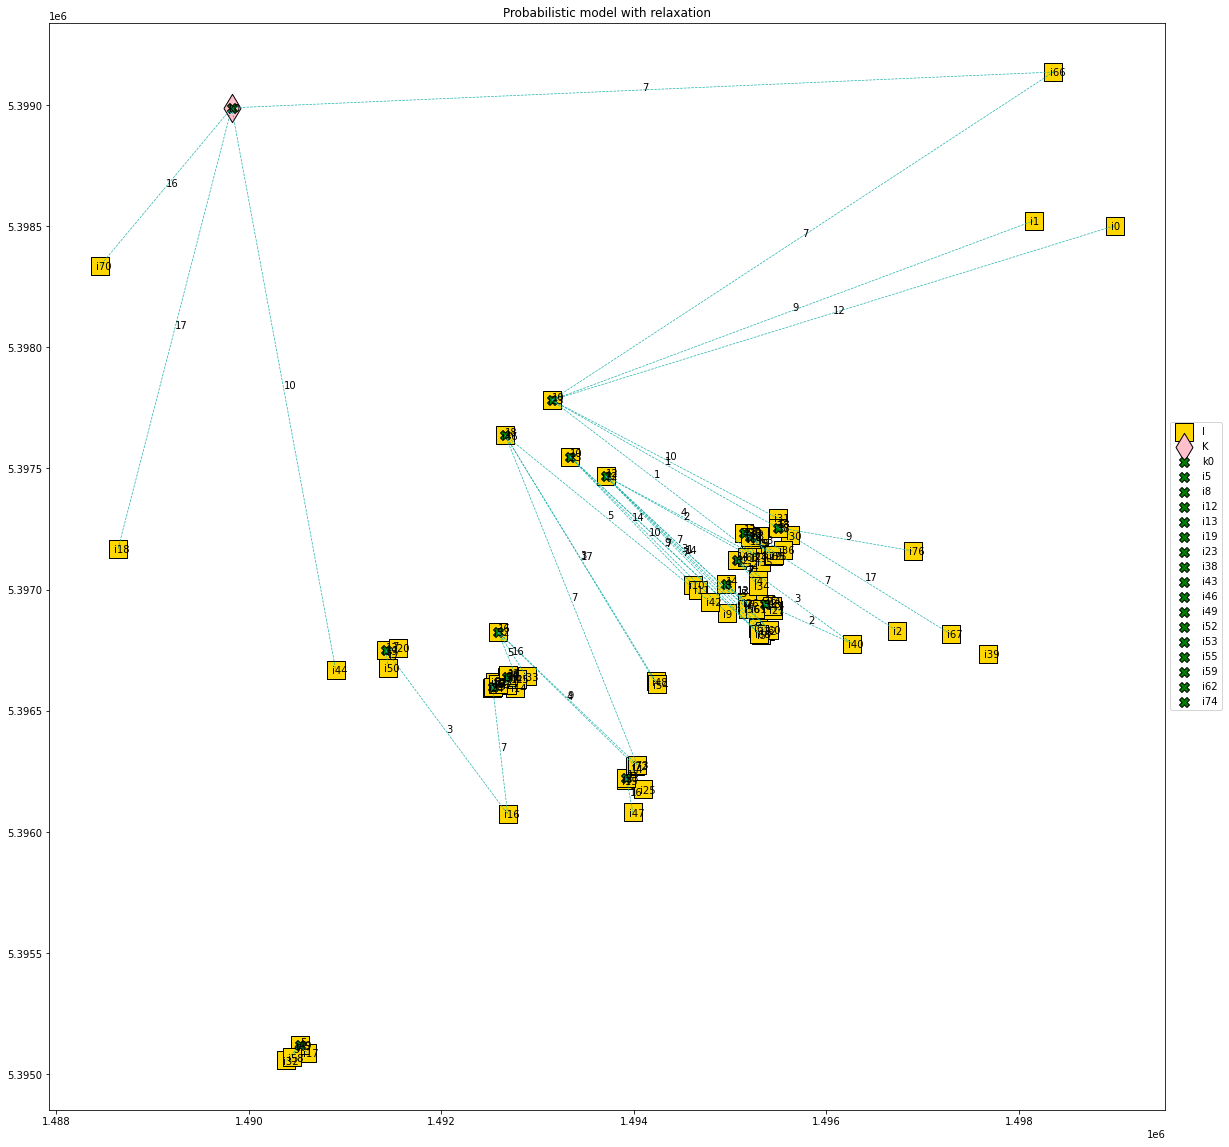

In [64]:
SolutionGraph(I, K, J, model_prob_rel)

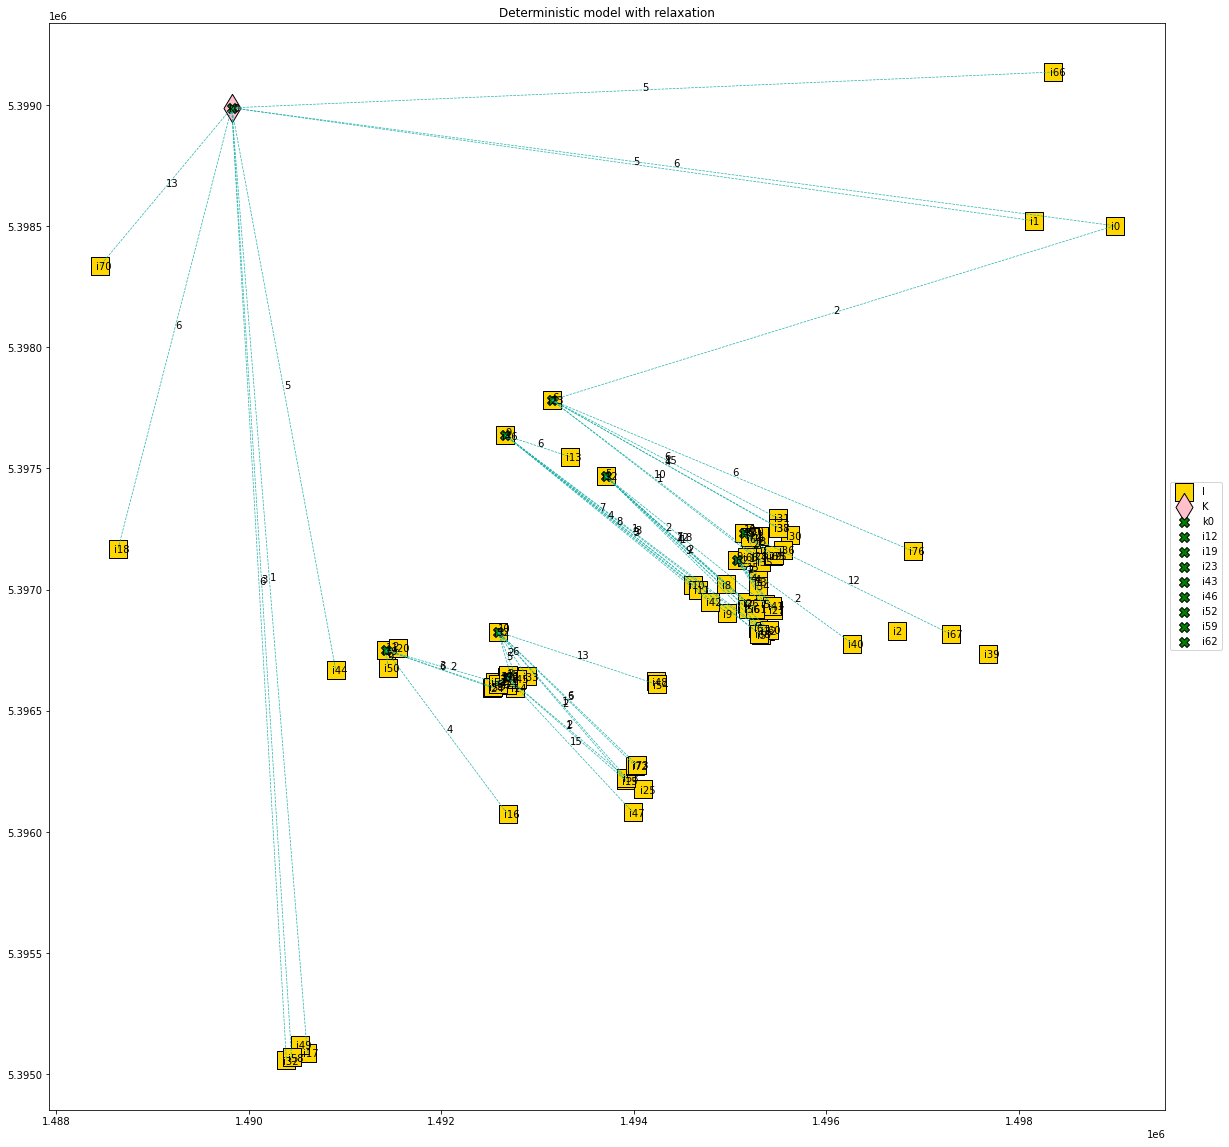

In [65]:
SolutionGraph(I, K, J, model_det_rel)

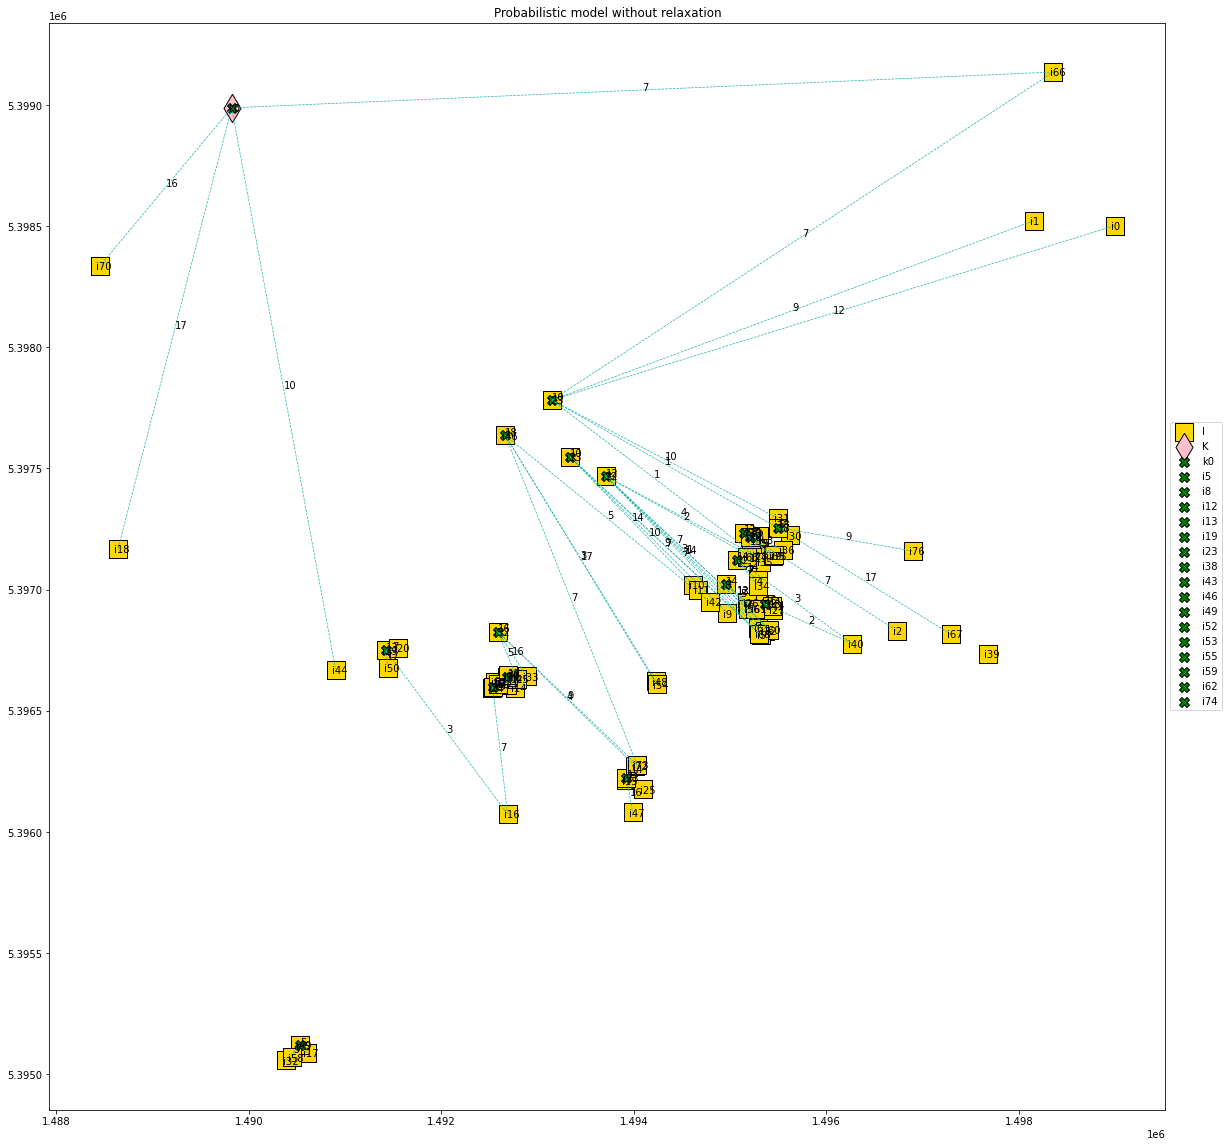

In [66]:
SolutionGraph(I, K, J, model_prob)

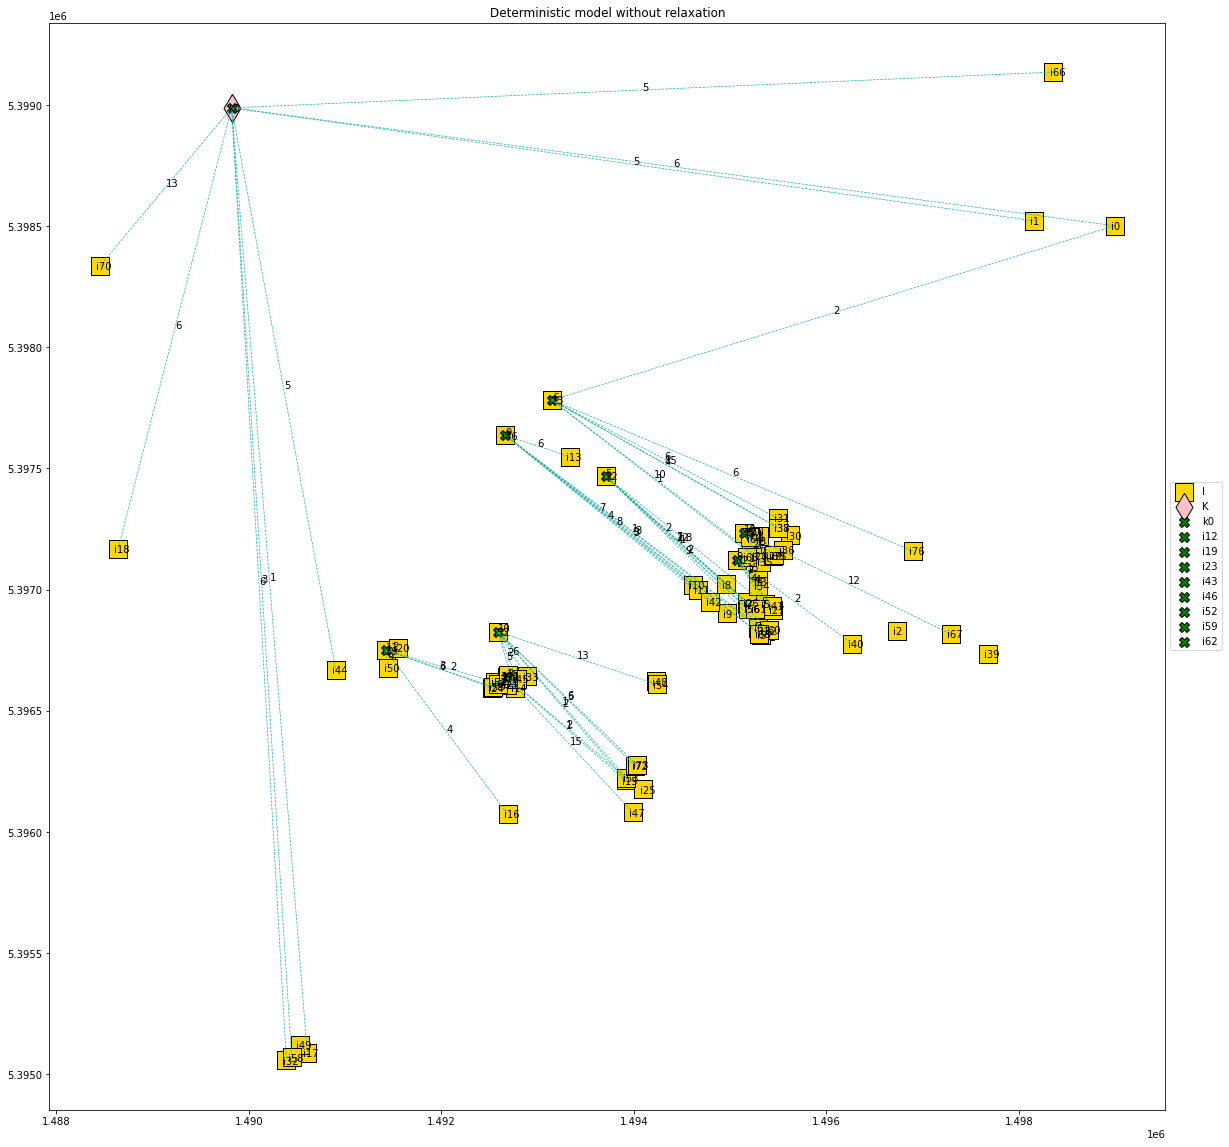

In [67]:
SolutionGraph(I, K, J, model_det)

1) complete information optimum - lower bound for optimum
2) price of uncertainty